In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import sirf.STIR as STIR
import scipy.ndimage as ndi
STIR.AcquisitionData.set_storage_scheme('memory')

In [2]:
data_path = '/mnt/share/petric/Siemens_mMR_NEMA_IQ'

In [3]:
STIR.set_verbosity(1)

In [4]:
def rdp_grad (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(np.abs(inpImm_)+ np.abs(shiftImm_) + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_
    


In [5]:
def rdp_step_size (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    ssNum = 0
    ssDen = 0
   # denImm_ = inpImm_ + alpha * sDir_
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
                wI = 1/(np.abs(inpImm_)+ np.abs(shiftImm_) + alpha_ * (sDir_ + shiftSI_) + 2 * np.abs(inpImm_-shiftImm_+ alpha_ * (sDir_ - shiftSI_)) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                ssNum -= np.matmul((inpImm_-shiftImm_).flatten().T,((sDir_-shiftSI_)*wI).flat)
                ssDen += np.matmul((shiftSI_-sDir_).flatten().T,((shiftSI_-sDir_)*wI).flat)
    return ssNum,ssDen

In [6]:
def rdp_value (inpImm_,kappa_,eps_,pixS_):
    val=0
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))    
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]     
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                wI = 1/(np.abs(inpImm_) + np.abs(shiftImm_)  + 2 * np.abs(inpImm_-shiftImm_) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                val += np.sum(np.sum(np.sum( (inpImm_-shiftImm_)**2 * wI ,axis=-1),axis=-1),axis=-1)
        return val

In [7]:
image = STIR.ImageData(os.path.join(data_path, 'OSEM_image.hv'))

In [8]:
kappa = STIR.ImageData(os.path.join(data_path, 'kappa.hv'))

In [9]:
stir_prior = STIR.CudaRelativeDifferencePrior()

In [10]:
stir_prior.set_epsilon(image.max()*1e-3)
stir_prior.set_penalisation_factor(1/700)
stir_prior.set_kappa(kappa)
stir_prior.set_up(image)

In [11]:
# stirG = stir_prior.gradient(image)

In [12]:
inpImage = image.as_array()

In [13]:
refImm = STIR.ImageData('/workdir/refs/nema_mMR/reference_image.hv')

# Reconstruction

In [14]:
acq_model = STIR.AcquisitionModelUsingParallelproj()
template = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'))
multCorr = STIR.AcquisitionData(os.path.join(data_path,'mult_factors.hs'))
addCorr = STIR.AcquisitionData(os.path.join(data_path,'additive_term.hs'))

rMax = addCorr.max()*1e-6
addCorr +=rMax
acq_model.set_acquisition_sensitivity(STIR.AcquisitionSensitivityModel(multCorr))
acq_model.set_additive_term(addCorr)
acq_model.set_up(template, image)
ss_model = acq_model.get_linear_acquisition_model()

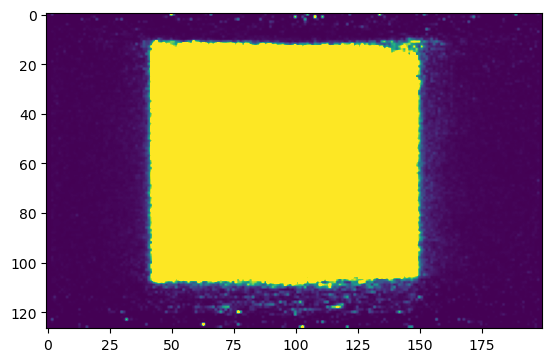

In [18]:
plt.imshow(inpImage[:,:,100],vmax=inpImage.max()*1e-2)

# PGA

## Compute diagonal preconditioner as the diagonal of the hessian 

(BP(attenuation^2))

In [20]:


fwdProj = acq_model.forward(image)
fp1 = ss_model.forward(image.get_uniform_copy(1))

myK = acq_model.backward(fp1/fwdProj)
myKsqroot = np.sqrt(myK.as_array()+1e-10)


### compute masks

In [21]:
mask = kappa.as_array()<1
print(mask.dtype)
mask = ndi.binary_dilation(mask)
print(mask.dtype)
mask = 1 - mask
print(mask.dtype)
#maskImm = STIR.ImageData(
maskS = image.get_uniform_copy(0)
maskS.fill(mask)

bool
bool
int64


In [22]:
mask = mask.astype(bool)

In [23]:
penEps = 1e-2*inpImage.max()
myKArr = myKsqroot**2
thr = np.percentile(myKArr[mask],10)*10
maskSDir = myKArr<thr
maskSDir = inpImage>penEps
maskSDir[0,:,:]=0
maskSDir[-1,:,:]=0

The border line often has numerical instability, let alone the area outside the circle which is NaN by definition. Define a mask

In [24]:
def makeFFT_2D_filter (imShape_):
    d_ = .65
    order = np.power(2,np.ceil(np.log2(imShape_[1]))).astype(np.uint32)
   # freqN = np.power(2,np.ceil(np.log2(imShape_[1]//2))).astype(np.uint32)
    print (order)
    freqN = order//2
    imShape_ = inpImage.shape
    nFreq = np.arange(0,freqN +1)
    filtImpResp = np.zeros((len(nFreq),))
    filtImpResp[0]=1/4
    filtImpResp[1::2]=-1/((np.pi*nFreq[1::2])**2)
    filtImpResp = np.concatenate([filtImpResp,filtImpResp[-2:0:-1]])
    ftFilt = 2 * np.real(np.fft.fft(filtImpResp)) # check! when implemented correctly the imag part is zero within numerical precision
    ftFilt = ftFilt[:(freqN+1)]
    
    #fMax = freqN
    fV = 2*np.pi*(np.arange(1,freqN+1))/imShape_[1]
    ftFilt[1:] *= (np.sin(fV/(2*d_)) / (fV/(2*d_)))
    ftFilt[ftFilt<0]=0
    
    xf = np.arange(0,imShape_[1]//2+1).reshape((1,imShape_[1]//2+1))
    yf = xf.transpose()
    freqR = np.sqrt(xf**2+yf**2)
    interpF = np.interp(freqR,nFreq,ftFilt,right=0)
    interpF = np.concatenate([interpF,interpF[-2:0:-1,:]],axis=0)
    interpF = np.concatenate([interpF,interpF[:,-2:0:-1]],axis=1)
    interpF = interpF.reshape((1,)+imShape_[1:])
    return interpF
    
    #invFFilt = np.fft.ifft(np.real(ftFilt)) 

#filtImpResp = 


In [25]:
myFilt = makeFFT_2D_filter(inpImage.shape)

256


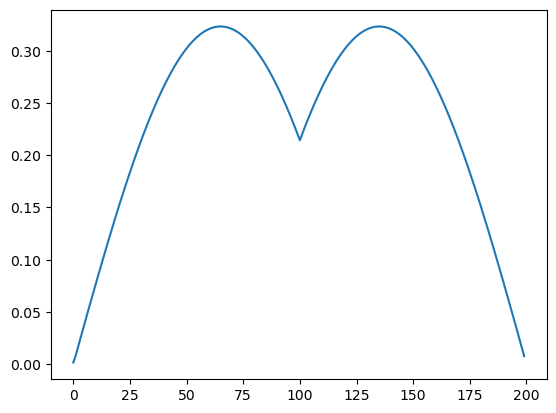

In [26]:
plt.plot(myFilt[0,0,:])

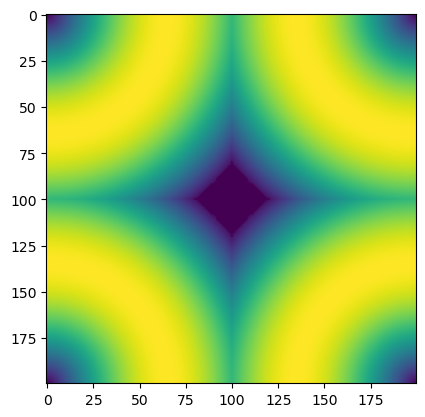

In [27]:
plt.imshow(myFilt[0,:,:])

## Actual recon loop

Recon with preconditioned, maybe conjugate gradient descent

In [58]:
# UNCOMMENT and run to "restart" from the clean image
import time
ts = time.time()
image.fill(inpImage)
print(time.time()-ts)

0.1627194881439209


In [98]:
import scipy.ndimage as ndi

image.fill(ndi.gaussian_filter(inpImage,1.05))

In [99]:
acq_model.forward(image,out=fwdProj)

In [31]:
addCorrArray = (addCorr*multCorr).as_array()
addCorrArray += 1e-6*addCorrArray.max()

In [32]:
addCorrArray.min()

1.0705998e-06

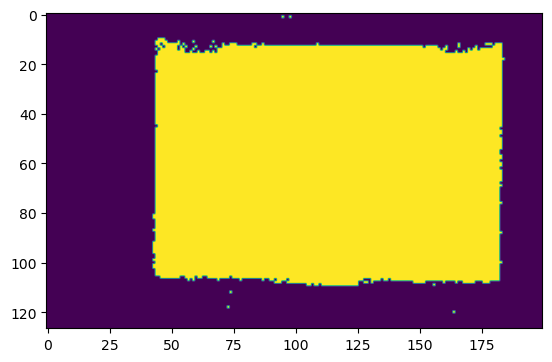

In [33]:
plt.imshow(maskSDir[:,100,:],vmax=1.)
#plt.colorbar()

In [100]:
nIt = 10
# initialize the current estimate
#addCorr += rMax
#fwdProj = acq_model.forward(image)
#fwdProj += addCorr
#fwdProj *= multCorr 
#fwdProj += rMax
recItV_Ff2 = np.zeros((nIt+1,) + inpImage.shape)
recItV_Ff2[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-2*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)
sinDenoStir = fwdProj.clone()

for itIdx in range(nIt):
#    gradSino =  (template-fwdProj)/sinDenoStir
    gradSino = template/fwdProj - 1
    acq_model.backward(gradSino,out=gradI) #*multCorr)
    pGrad = stir_prior.gradient(image)
 #   pGradA = betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
 #   pGrad.fill(pGradA)
    grad = gradI - pGrad

 #   sDir = grad*maskS / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1
  # break
  # gradArr = gradI.as_array() - betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    gradArr = grad.as_array()
    gradArr /= myKsqroot
    gradArr = np.fft.fft2(gradArr,axes=(1,2))
    gradArr *= myFilt
    gradArr = np.real(np.fft.ifft2(gradArr,axes=(1,2)))
    gradArr = ndi.gaussian_filter(gradArr,(0.5,0,0))
    gradArr /= myKsqroot
    sDir.fill(gradArr*mask)
 #   break
    # #  

    # Uncomment to conver to conjugate 
    
    # if itIdx>0:
    #     beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
    #     sDir += beta * prevSDir 
    # prevSDir = sDir.clone()
    # gradP = grad.clone()   

    ss_model.forward(sDir,out=fPsDir) #*multCorr

    # Tomographic step size
    
    ssNum = sDir.dot(gradI)
#  0  ssDen = fPsDir.dot((fPsDir/fwdProj)*(template/fwdProj))
    ssDen = fPsDir.dot((fPsDir/fwdProj))
  #  ssDen = fPsDir.dot((fPsDir/sinDenoStir))
    ssTomo = ssNum/ssDen
    #ss = ssTomo
    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array()*maskSDir,penEps,image.voxel_sizes())
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    print ('num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))
#    break
    
    # update image and sinogram
    prevImm = image.clone()
    image += ss*sDir
  #  fwdProj += ss*fPsDir
 #   print(ss)

# UNCOMMENT to update sinogram in each iteration
    

    imArr = image.as_array()
    imArr[imArr<0]=0
    imArr[np.isnan(imArr)] = 0
    if itIdx<1:
        imArr*=maskSDir
    image.fill(imArr)
    acq_model.forward(image,out=fwdProj)
    prevSDir = (image - prevImm)/ss
    # if itIdx<1:
    #     prevSDir*=maskSDir

    # sinDeno = fwdProj.as_array()
    # sinDeno[sinDeno<addCorrArray] = addCorrArray[sinDeno<addCorrArray]
    # sinDenoStir.fill(sinDeno)
    # ts = time.time()
    # fwdProj += addCorr 
    # t1 = time.time()
    # fwdProj *= multCorr 
    # t2 = time.time()
   # if (itIdx%20)==0:
   #  print(itIdx)
    

  #  fwdProj+= ss/ssDen*fPsDir
    recItV_Ff2[itIdx+1,:,:,:] = image.as_array()
    
    

num: -4.7e+02 den: 1.9e+02 penNum 1.2e+04 penDen 3.3e+03
num: 1.7e+03 den: 1.3e+03 penNum -2.9e+04 penDen 1.5e+04
num: 3.1e+03 den: 1.9e+03 penNum -7.8e+03 penDen 3.6e+04
num: 3.3e+03 den: 2.0e+03 penNum -3.8e+03 penDen 4.0e+04
num: 3.4e+03 den: 2.0e+03 penNum -3.4e+03 penDen 4.0e+04
num: 3.4e+03 den: 2.0e+03 penNum -3.4e+03 penDen 4.0e+04
num: 3.4e+03 den: 2.0e+03 penNum -3.4e+03 penDen 4.0e+04


KeyboardInterrupt: 

In [49]:
ss_model.forward(sDir,out=fPsDir)

In [59]:
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array()*maskSDir,penEps,image.voxel_sizes())

In [61]:
penSSNum/ penSSDen

3.5775872913800164

In [50]:
ssNum = sDir.dot(gradI)

In [52]:
ssNum, fPsDir.dot((fPsDir/fwdProj))

(-473.23544, 191.14777)

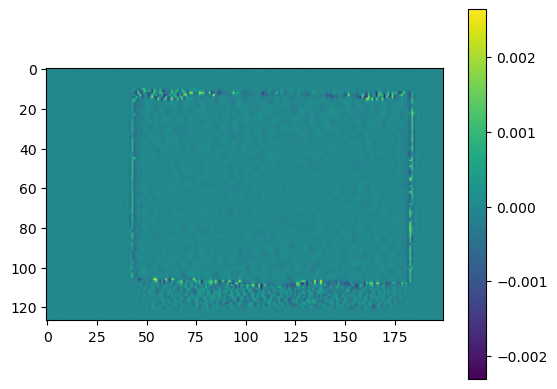

In [97]:
plt.imshow((sDir.as_array()+1e-10)[:,100,:])
plt.colorbar()

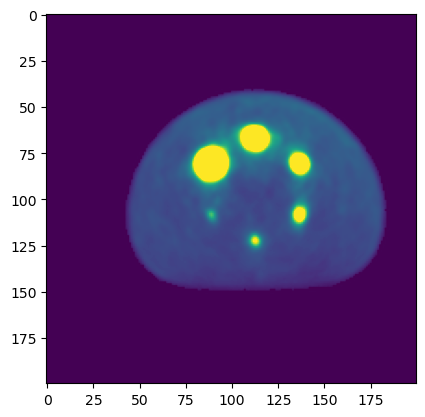

In [108]:
plt.imshow((image).as_array()[72,:,:],vmax=.05)

In [79]:
tA = ((pGrad/(myK+1e-10)).as_array())

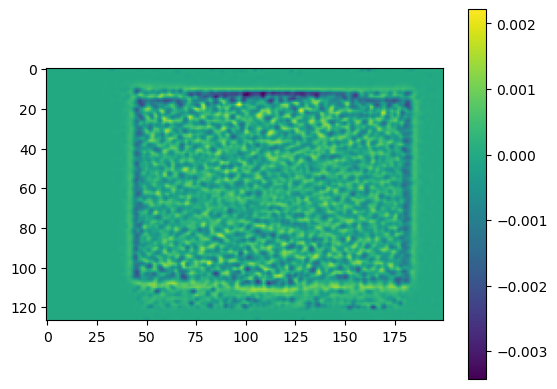

In [82]:
#plt.imshow((gradI/myK+1e-10).as_array()[72,:,:])
plt.imshow((-tA)[:,100,:])
plt.colorbar()

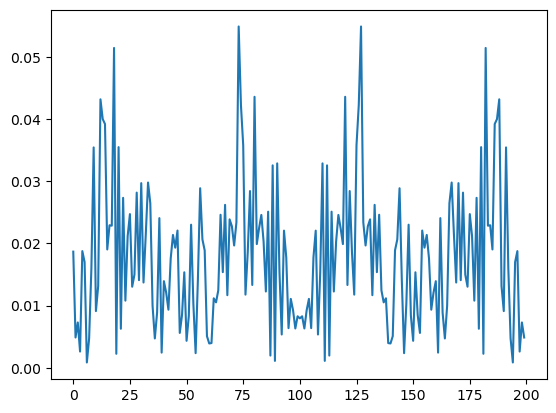

In [67]:
plt.plot(np.abs(np.fft.fft2(sDir.as_array()[72,:,:]))[0,:])

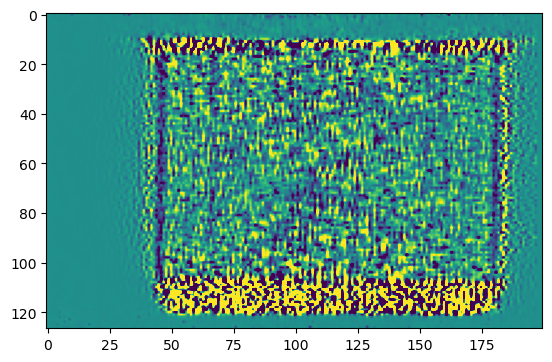

In [68]:
#mask3 = (inpImage>(penEps))
plt.imshow(sDir.as_array()[:,100,:],vmax=2e-4,vmin=-2e-4) #,vmax=0.152)
#plt.contour(maskSDir[72,:,:])
#plt.colorbar()
#plt.contour(mask3[:,100,:],0,colors='r')

In [163]:
sDir.dot(grad)

17079.477

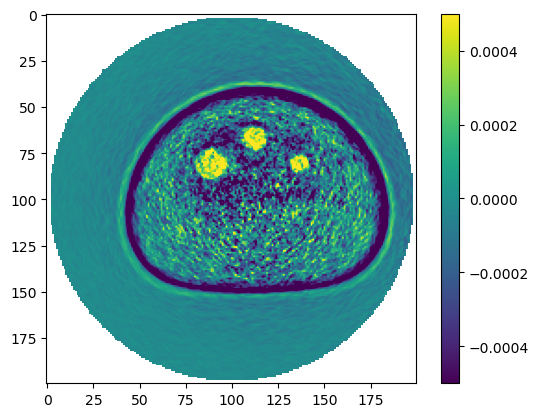

In [161]:
plt.imshow((gradP/myK).as_array()[72,:,:],vmax=5e-4,vmin=-5e-4) #,vmax=0.152)
plt.colorbar()

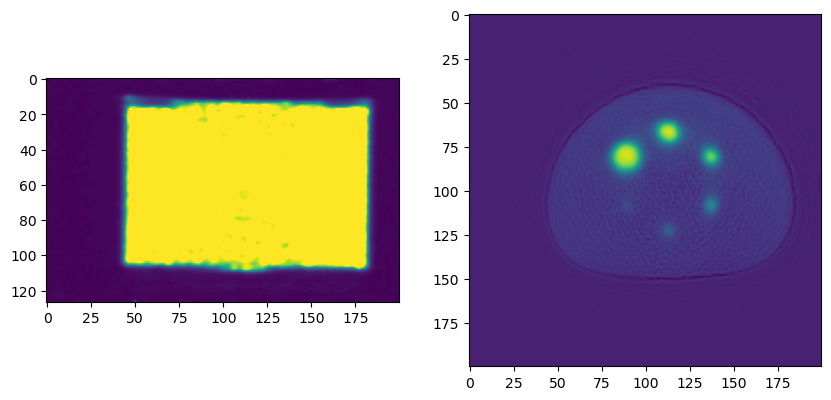

In [169]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(recItV_C_F_M2[4,:,100,:],vmax=0.01)
plt.subplot(122)
plt.imshow(recItV_Ff2[-1,72,:,:],vmax=0.16)

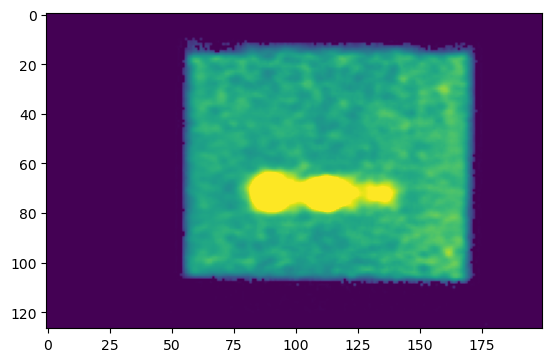

In [102]:
#mask3 = (inpImage>(penEps))
plt.imshow(image.as_array()[:,72,:],vmax=0.022)
#plt.contour(mask3[:,100,:],0,colors='r')2

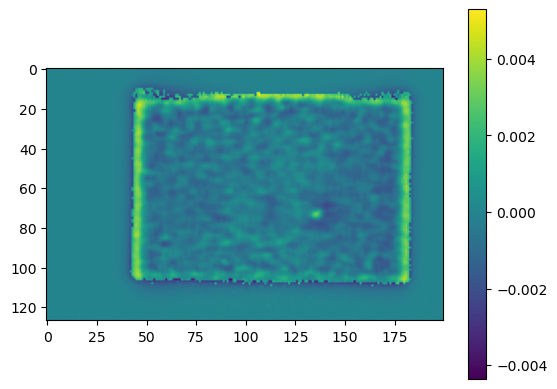

In [103]:
plt.imshow((image.as_array()-recImmCG)[:,115,:])#,vmax=0.120)
plt.colorbar()

# Plot convergence

In [44]:
recImmCG =  refImm.as_array()#np.load('refImm.npy')
recImmCG2 = np.load('refImm.npy')

Text(0, 0.5, 'Difference norm')

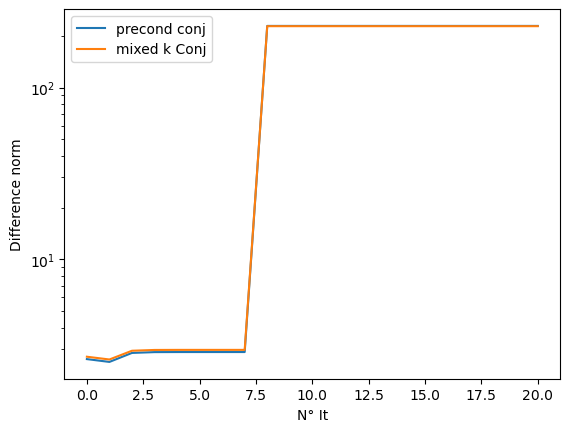

In [101]:

# dV = np.sum(np.sum(np.sum((recItV_C_F_M2[:10,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)


# dV = np.sum(np.sum(np.sum((recItV_C[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)

# dV = np.sum(np.sum(np.sum((recItV_F2[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_Ff2[:,:,:,:]-np.expand_dims(recImmCG2,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_Ff2[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)
#plt.xlim(0,20)
#plt.ylim(1e-2,4)
#plt.plot(np.arange(0,10),10/(np.arange(1,11)))
plt.yscale('log')
plt.legend(['precond conj','mixed k Conj','mixed k Conj F','precond','F','F higher','F2_F','F2_Fs','F3_F3'])
plt.xlabel('N° It')
plt.ylabel('Difference norm')


/tmp/ipykernel_54962/2447047064.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow((1/myK.as_array())[:,100,:])


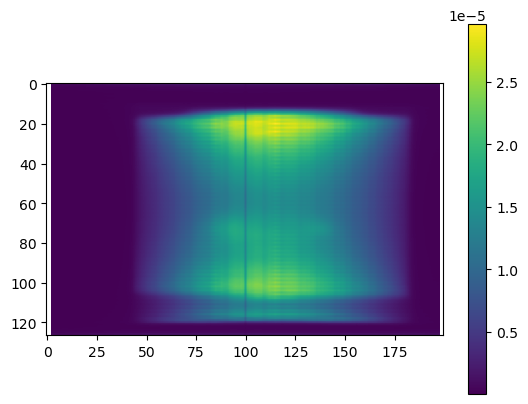

In [201]:
plt.imshow((1/myK.as_array())[:,100,:])
plt.colorbar()

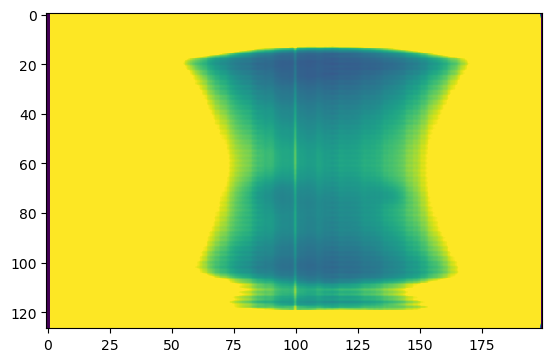

In [134]:
plt.imshow((myK.as_array())[:,100,:],vmax=609)
#plt.contour(maskSDir[72,:,:],0)
#plt.colorbar()

In [193]:
penSSNum, penSSDen = rdp_step_size(inpImage,ndi.gaussian_filter(sDir.as_array(),.2),kappa.as_array(),penEps,image.voxel_sizes())
print('{:.2e}, {:.2e}'.format(betaPen*penSSNum, betaPen*penSSDen))

-3.58e+07, 3.21e+09


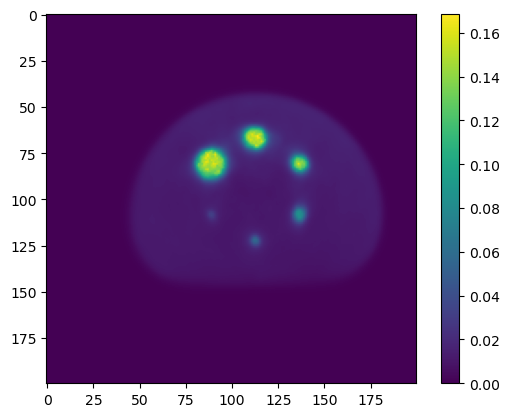

In [97]:
plt.imshow(ndi.gaussian_filter((image).as_array(),.1)[72,:,:])
plt.colorbar()


In [36]:
'{:.2e}, {:.2e}'.format(ssNum, betaPen*penSSNum)

NameError: name 'penSSNum' is not defined

In [37]:
'{:.2e}, {:.2e}'.format(ssDen, betaPen*penSSDen)

NameError: name 'penSSDen' is not defined

In [121]:
sT #= 0.0024

array([0.        , 0.00011111, 0.00022222, 0.00033333, 0.00044444,
       0.00055556, 0.00066667, 0.00077778, 0.00088889, 0.001     ])

# Test step size of prior

In [231]:
inpImm_ = inpImage
sDir_ = sDir.as_array() #(grad/(myK+1e-10)).as_array()
eps_ = penEps
pixS_ = image.voxel_sizes()
kappa_ = kappa.as_array().copy() #kappa.as_array()
alpha_ = 0

In [232]:
ssNum = 0
ssDen = 0
   # denImm_ = inpImm_ + alpha * sDir_
for xs in range(-1,2):
    for ys in range (-1,2):
        for zs in range(-1,2):
            if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                continue
            shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
            shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
            sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
            if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
            if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
            wI = 1/(np.abs(inpImm_)+ np.abs(shiftImm_) + alpha_ * (sDir_ + shiftSI_) + 2 * np.abs(inpImm_-shiftImm_+ alpha_ * (sDir_ - shiftSI_)) + eps_)
            wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
            ssNum -= np.matmul((inpImm_-shiftImm_).flatten().T,((sDir_-shiftSI_)*wI).flat)
            ssDen += np.matmul((shiftSI_-sDir_).flatten().T,((shiftSI_-sDir_)*wI).flat)
            break
        break
    break

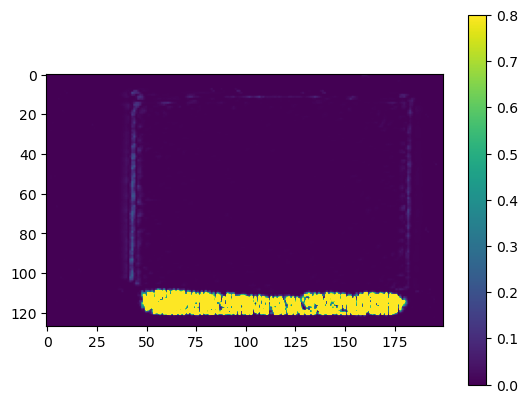

In [233]:
plt.imshow(((shiftSI_-sDir_)*wI*((shiftSI_-sDir_)))[:,100,:],vmax=.8)
plt.colorbar()

In [241]:
kappa_.shape

(127, 200, 200)

(40000.0, 200000.0)

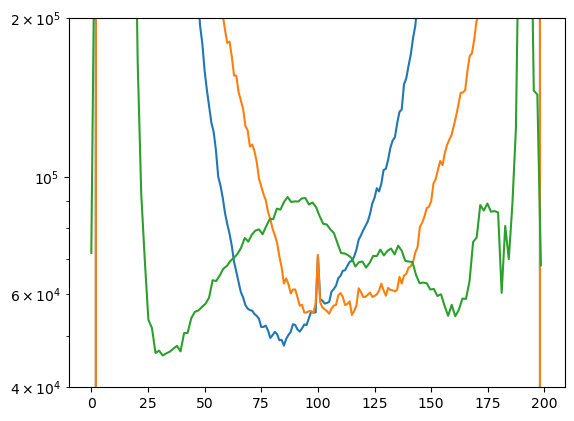

In [242]:
plt.plot((kappa_*kappa_)[72,:,100])
plt.plot((kappa_*kappa_)[72,100,:])
plt.plot(np.arange(127)*200/127,(kappa_*kappa_)[:,100,100])
plt.yscale('log')
plt.ylim(4e4,2e5)
#,vmax=300000)plt.colorbar()

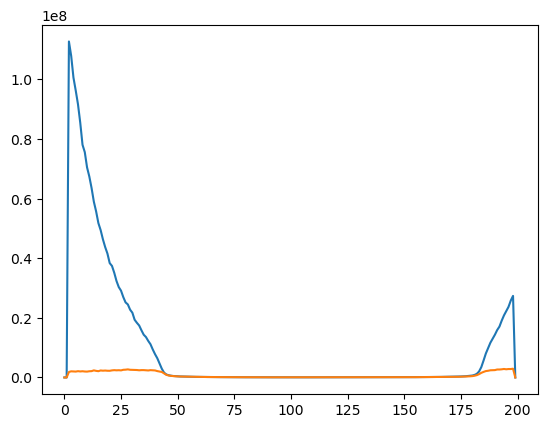

In [295]:
plt.plot(myK.as_array()[72,100,:]*190)
plt.plot((kappa_*kappa_)[72,100,:])
#plt.ylim(0,2e5)
#plt.yscale('log')

In [353]:
obFV = np.zeros((len(sT),2))
sinoA = template.as_array()
sinBar = fwdProj.as_array()
fpSD = fPsDir.as_array()
for idx,sEl in enumerate(sT):
    sinNext = sinBar + sEl*fpSD
    sinNext[sinNext<1e-10] = 1e-10
    obFV[idx,0] = np.sum(sinNext - sinoA*np.log(sinNext))
    obFV[idx,1] = rdp_value((image+sEl*sDir).as_array(),kappa.as_array(),penEps,image.voxel_sizes())/700

(0.0, 10000.0)

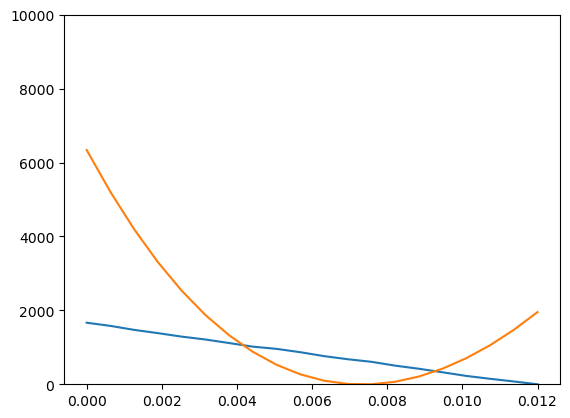

In [354]:
plt.plot(sT,obFV-np.expand_dims(np.min(obFV,axis=0),axis=0))
plt.ylim(0,10000)

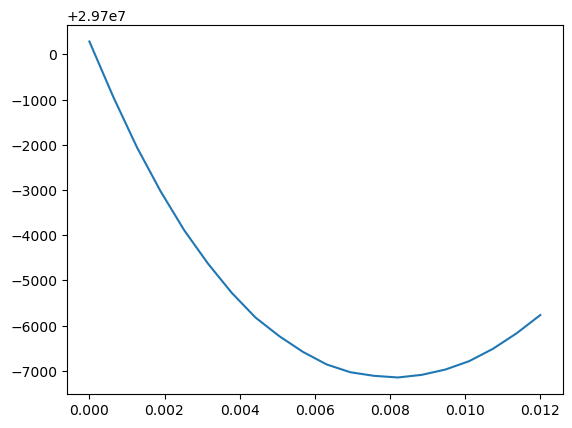

In [358]:
plt.plot(sT,np.sum(obFV,axis=1))
#plt.ylim(2.969e7,2.975e7)

In [209]:
obFV[:,1] /obFV[:,0]

array([0.74883198, 0.74986394, 0.75008898, 0.74926898, 0.751001  ,
       0.74511805])

In [321]:
sT = np.linspace(0.0026,0.004,20)

In [322]:
obFV = np.zeros((len(sT),2))
for idx,sEl in enumerate(sT):
  #  obFV[idx,0] = stir_prior.get_value(image+sEl*sDir)
    obFV[idx,0] = rdp_value((image+sEl*sDir).as_array(),kappa.as_array(),penEps,image.voxel_sizes())/700

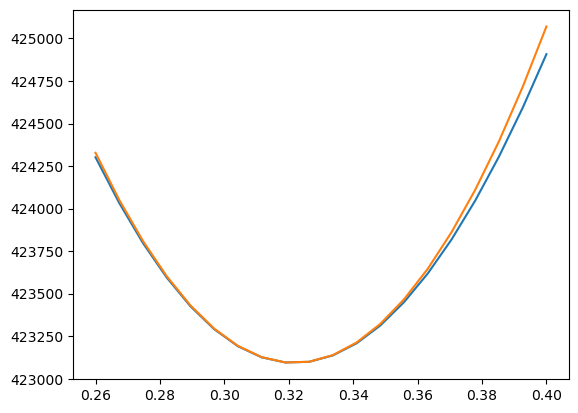

In [323]:
plt.plot(sT*100,obFV[:,0])
plt.plot(sT*100,423093+0.6667*0.25*1.94e10*(sT-0.003218)**2)
#plt.ylim(422000,450000)

In [248]:
445000-423000, 0.5*1.94e+10*(0.0025)**2

(22000, 60625.0)

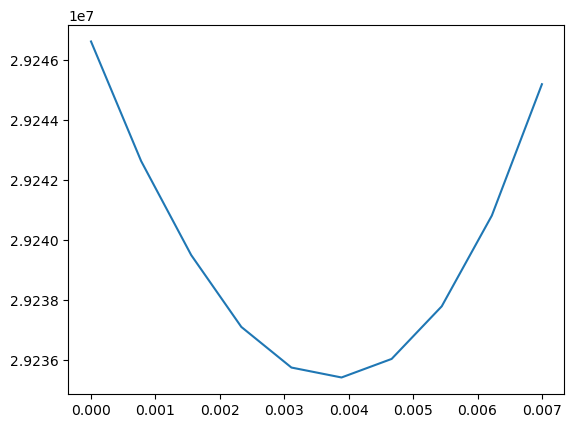

In [142]:
plt.plot(sT,obFV[:,0])
#plt.ylim(500000,600000)
#plt.plot(np.sum(obFV,axis=1))

In [223]:
1.37e9*(0.003)**2/2, 2.92450e7-2.9236e7

(6165.0, 9000.0)

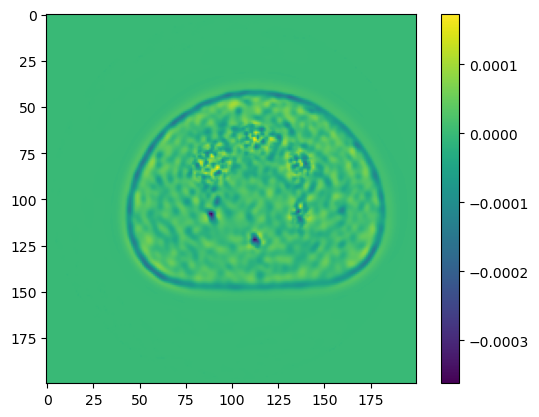

In [208]:
plt.imshow((sDir).as_array()[72,:,:])
plt.colorbar()

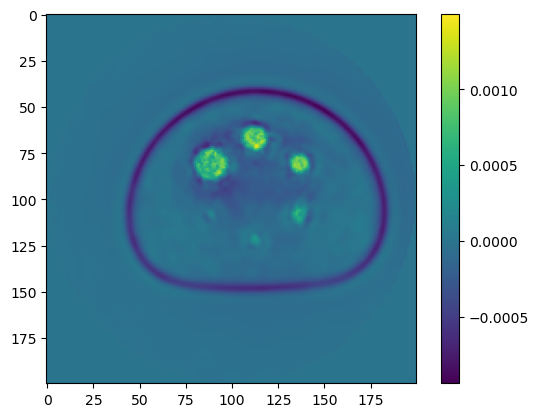

In [157]:
plt.imshow((grad/(myK+1e-10)).as_array()[72,:,:])
plt.colorbar()

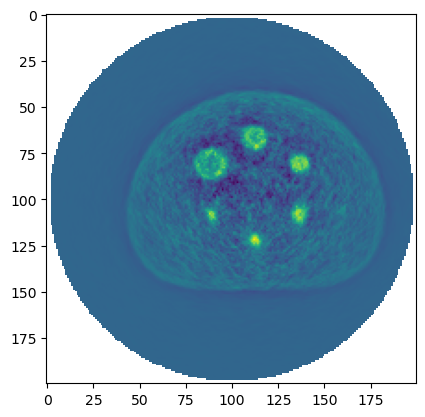

In [70]:
plt.imshow((gradI/myK).as_array()[72,:,:])

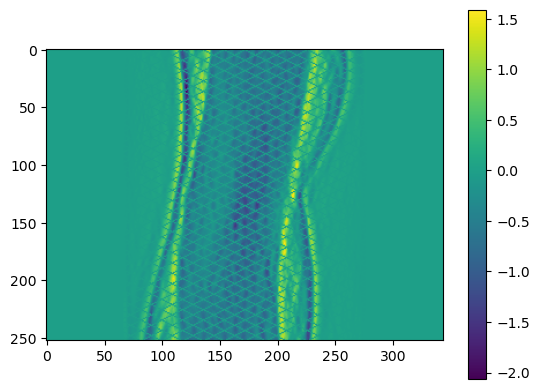

In [26]:
plt.imshow((fPsDir).as_array()[0,12,:,:])
plt.colorbar()

In [149]:
print ('num: {:.1e} den: {:.1e}'.format(ssNum,ssDen))

num: -2.7e+07 den: nan


In [27]:
ssTomo, penSSNum/penSSDen, ss

(-0.06658192, 0.00043668497166960557, 0.0004158140401747631)

In [168]:
ssTomo, penSSNum/penSSDen, ss

(-0.001608604, 0.00043526562888113375, 0.00039478454333196933)

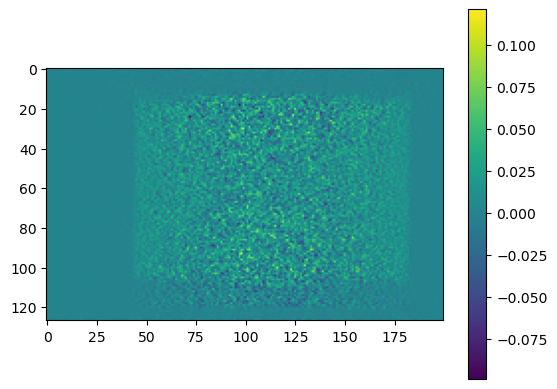

In [154]:
#rImm = grad.as_array()[:,100,:]/(myKsqroot[:,100,:]**2)/(sDir.as_array()[:,100,:])
plt.imshow(image.as_array()[:,100,:]) #,vmin=0,vmax=.16) #-inpImage[72,:,:])
plt.colorbar()

In [193]:
myG = rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
theirG = stir_prior.gradient(image)

continuing


In [28]:
#recItV_CG = recItV.copy()
recImmCG = image.as_array()

In [104]:
import time
#ts = time.time()
fPsDir.dot(fPsDir/(fwdProj+ss*fPsDir))/ssDen #2559751200
#,  2559751200.0
#print (ts-time.time())

0.9567885

In [126]:
upPSSN, upPSSD = rdp_step_size (inpImage,sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes(), ss/1)

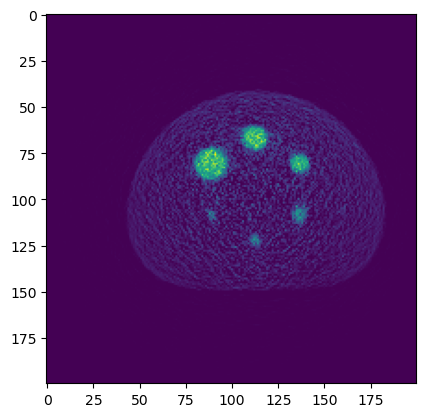

In [543]:
plt.imshow(recItV_unreg_noP_F[0,72,:,:])

### Plot some images

In [45]:
np.save('ref_imm.npy',recItV_CG)

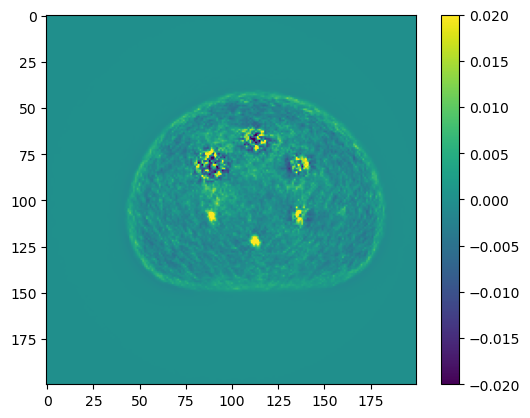

In [510]:
plt.imshow(recItV_NNfilt_Sm_ntP[0,72,:,:]-recImmCG[72,:,:],vmin=-.02,vmax=.02)
plt.colorbar()

In [48]:
recItV_CG.nbytes/np.power(2,20)

1937.8662109375

In [50]:
np.save('recIt_diagPrecond.npy',recItV)

In [51]:
np.save('refImm.npy',recImmCG)

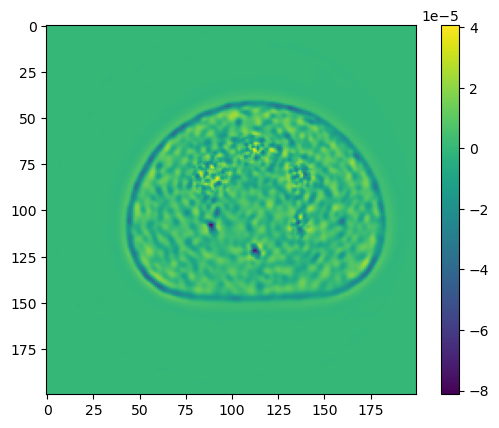

In [176]:
plt.imshow(ss*sDir.as_array()[72,:,:])
plt.colorbar()

/tmp/ipykernel_50445/1781100817.py:2: RuntimeWarning: invalid value encountered in divide
  plt.imshow(gradI.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)
/tmp/ipykernel_50445/1781100817.py:5: RuntimeWarning: invalid value encountered in divide
  plt.imshow(gradP.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)


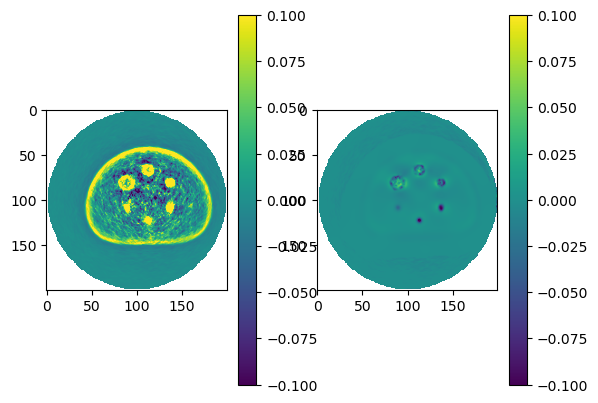

In [53]:
plt.subplot(121)
plt.imshow(gradI.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)
plt.colorbar()
plt.subplot(122)
plt.imshow(gradP.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)
plt.colorbar()

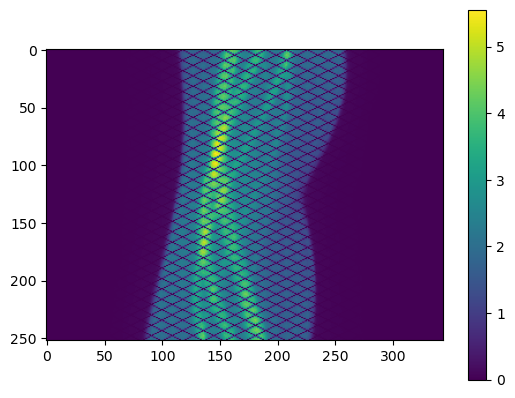

In [666]:
slIdx +=1
plt.imshow(tFP.as_array()[0,slIdx,:,:])
plt.colorbar()

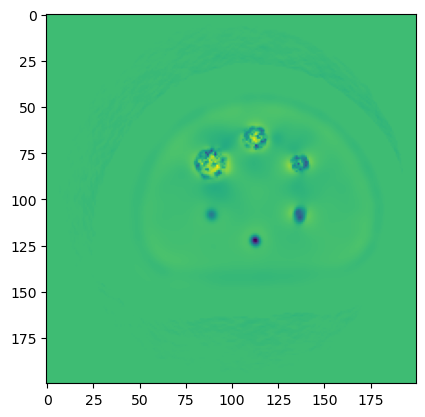

In [258]:
plt.imshow(sDir.as_array()[72,:,:]) #,vmax=400)

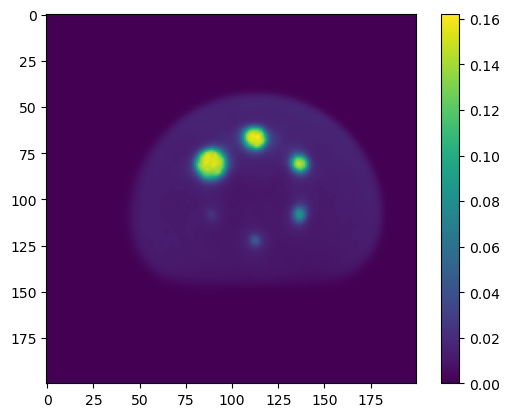

In [260]:
plt.imshow(image.as_array()[72,:,:]) #,vmax=.)
plt.colorbar()

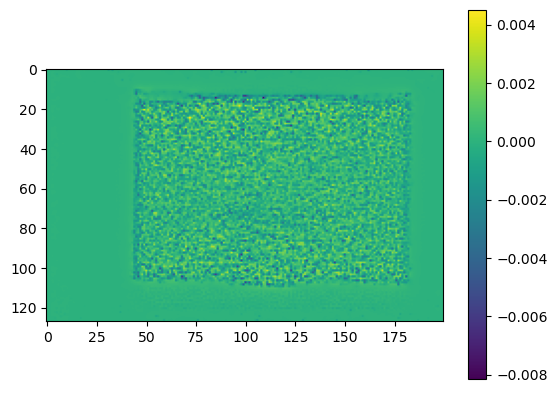

In [676]:
plt.imshow(recItV[18,:,100,:]-recItV[0,:,100,:])
plt.colorbar()

In [479]:
ss/ssDen

0.0

In [261]:
dV = np.sum(np.sum(np.sum(recItV-np.expand_dims(recItV[-1,:,:,:,],axis=0),axis=-1),axis=-1),axis=-1)**2
plt.plot(dV)

NameError: name 'recItV' is not defined

In [27]:
import scipy.ndimage as ndi

/tmp/ipykernel_11022/2359744373.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(sDir.as_array()[:,100,:]/kappa.as_array()[:,100,:],vmin=-0.00003,vmax=.00003)


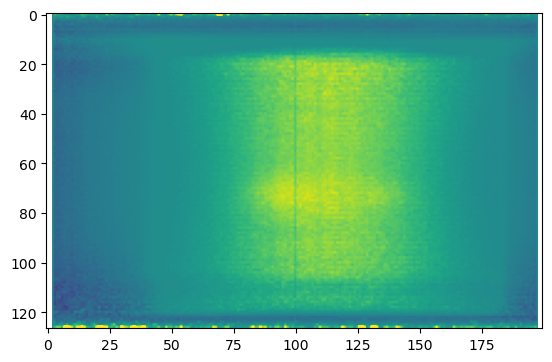

In [457]:
plt.imshow(sDir.as_array()[:,100,:]/kappa.as_array()[:,100,:],vmin=-0.00003,vmax=.00003)
#plt.colorbar()

/tmp/ipykernel_11022/2999593000.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)
/tmp/ipykernel_11022/2999593000.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)


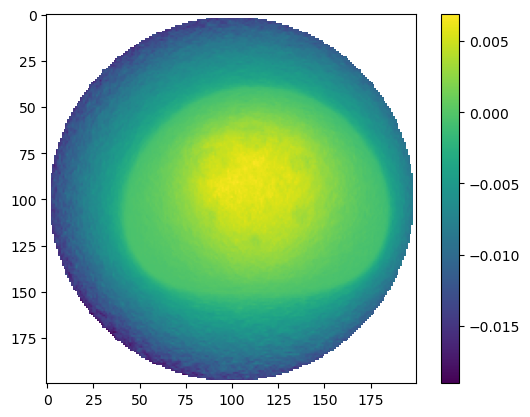

In [415]:

plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)
plt.colorbar()

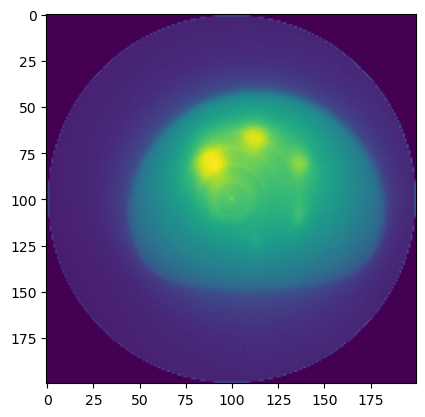

In [331]:
plt.imshow(bkwP.as_array()[72,:,:]/(kappa.as_array()[72,:,:]))